# LED Calibration Script

### Run these cells for initialization

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from scipy.optimize import curve_fit
import straxbra
from pymongo import MongoClient
import os
import strax

In [2]:
ctx = straxbra.XebraContext(register=[straxbra.plugins.DAQReader],
                            config={'do_breaks' : False})
all_gains = {}

### Run this cell prior to GainAnalysis


In [297]:
def gaus(x, mu, sig, amp):
    amp = max(1, amp)
    sig = max(1, sig)
    log_scale = np.log(amp) - 0.5*np.log(2*np.pi) - np.log(sig)
    log_exp = -(x - mu)**2/(2*sig**2)
    return np.exp(log_scale + log_exp)

def fit_fcn(x, *args):
    noise = list(args[0:3])
    s = gaus(x, *noise)
    spe = list(args[3:6])
    #spe[2] = spe[2]*noise[2]
    s += gaus(x, *spe)
    if len(args) > 6:
        dpe = list(args[6:9])
        dpe[0] = spe[0]*dpe[0]
        #dpe[2] = spe[2]*dpe[2]
        s += gaus(x, *dpe)
        if len(args) > 9:
            upe = list(args[9:12])
            upe[0] = upe[0]*spe[0]
            #upe[2] = upe[2]*spe[2]
            s += gaus(x, *upe)
    return s

def PlotForRun(context, run):
    fig, axs = plt.subplots(figsize=(18,12), nrows=3, ncols=3)
    raw = context.get_array(run, 'raw_records')
    
    window_low = 40
    window_high = 65
    
    bin_high = np.zeros(8, int)
    #bin_high = [1000, 2000, 2000, 3000, 2000, 1000, 1000, 2000]
    for ch in range(8):
        if(ch==0):
            bin_high[ch] = (np.quantile((raw['data'][raw['channel'] == ch, window_low:window_high].sum(axis=1)),0.999) //200 +1)*200
        else:
            bin_high[ch] = (np.quantile((raw['data'][raw['channel'] == ch, window_low:window_high].sum(axis=1)),0.9997) //200 +1)*200

    print(bin_high)
    
    colors = ['red', 'green', 'cyan', 'magenta', 'lime', 'orange']
    gains = {
        'bin_centers' : [],
        'histogram' : [],
        'popt' : [],
        'pconv' : [],
        'adc_to_pe' : [],
        'gain' : [],
        'run' : int(run),
    }
    nn = ['Noise mean','Noise sigma', 'Noise counts',
          '1pe mean', '1pe sigma', '1pe counts',
          '2pe mean scale', '2pe sigma', '2pe counts',
          'Uamp mean scale', 'Uamp sigma', 'Uamp counts']
    adc_to_e = (2.25/2**14) * (1e-8) * (1/50) * (1/1.602e-19) * (10)
    
    for ch in range(8):
        bins = np.linspace(-50,bin_high[ch],200)
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        bin_widths = bins[1:] - bins[:-1]
        ax = axs[ch//3][ch%3]
        
        n, _ = np.histogram(raw['data'][raw['channel'] == ch, window_low:window_high].sum(axis=1), bins=bins)
        sigma = np.maximum(np.ones_like(n), np.sqrt(n)/bin_widths)
        n = n/bin_widths
        ax.step(bin_centers, n, where='mid', c='k')
        gains['bin_centers'].append(bin_centers.tolist())
        gains['histogram'].append(n.tolist())
        cts = n.sum()
        spe_guess = bin_centers[np.argmax(n[50]) +50]
        
        ### Preliminiary fit with noise + spe Gaussian only
        bounds_prelim = np.array([
            [-50,-10,30],  # 0pe mean
            [10, 40, 100],   # 0pe sigma
            [cts/10, cts, cts*100], # 0pe counts
            [0.9*spe_guess, spe_guess, 2*spe_guess], # 1pe mean
            [0.2*spe_guess, spe_guess*0.5, 0.6*spe_guess], # 1pe sigma
            [cts/1e8, cts/1e1, cts/1e0], # 1pe counts
        ])            
        popt_prelim, pconv_prelim = curve_fit(fit_fcn, bin_centers, n, p0=bounds_prelim[:,1], sigma=sigma, bounds=bounds_prelim[:,[0,2]].T)
        
        ### Final fit with noise, spe, dpe & uamp contributions, based on preliminar fit results
        bounds = np.array([
            [popt_prelim[0] - 3* popt_prelim[1], popt_prelim[0],popt_prelim[0] + 3* popt_prelim[1]],  # 0pe mean
            [popt_prelim[1]/2, popt_prelim[1], popt_prelim[1]*2],   # 0pe sigma
            [popt_prelim[2]/5, popt_prelim[2], popt_prelim[2]*5], # 0pe counts
            [popt_prelim[3]*0.9, popt_prelim[3], popt_prelim[3]*2], # 1pe mean
            [popt_prelim[4]/2, popt_prelim[4], popt_prelim[4]*2], # 1pe sigma
            [popt_prelim[5]/100, popt_prelim[5]/2, popt_prelim[5]*10], # 1pe counts
            [1.8, 2, 2.4], # 2pe mean scale factor
            [popt_prelim[4], popt_prelim[4]*1.4, popt_prelim[4]*1.8], # 2pe sigma
            #[popt_prelim[5]/1e3, popt_prelim[5]/50, popt_prelim[5]/8], # 2pe counts
            [(popt_prelim[5]**2/ popt_prelim[2]) / 10, (popt_prelim[5]**2/ popt_prelim[2]), (popt_prelim[5]**2/ popt_prelim[2]) *10], # 2pe counts
            [0.01, 0.2, 0.6], # underamp mean scale factor
            [1, 10, 50], # underamp sigma
            [cts/1e6, cts/1e3, cts/1e1], # underamp counts
        ])
        try:
            popt, pconv = curve_fit(fit_fcn, bin_centers, n, p0=bounds[:,1],sigma=sigma, bounds=bounds[:,[0,2]].T)
            print('CH%i Xsq/NDF: %.3g/%.3g' % (ch,(((n-fit_fcn(bin_centers, *popt))/sigma)**2).sum(), len(n) - len(popt)))
            for a in zip(nn, popt, np.sqrt(np.diag(pconv))):
                print('CH%i: %s: %.3g +- %.3g' % (ch, *a))
            print()
            ax.plot(bin_centers, fit_fcn(bin_centers, *popt), linestyle='--', c='b')
            ax.plot(bin_centers, gaus(bin_centers, *popt[0:3]), c=colors[0], label = 'noise')  # noise
            ax.plot(bin_centers, gaus(bin_centers, *popt[3:6]), c=colors[1], label = 'single-pe')  # spe
            ax.plot(bin_centers, gaus(bin_centers, popt[6]*popt[3], popt[7], popt[8]), c=colors[2], label = 'double-pe')  # dpe
            ax.plot(bin_centers, gaus(bin_centers, popt[9]*popt[3], popt[10], popt[11]), c=colors[3], label = 'underampl.')  # upe
            ax.set_ylim(0.3,popt[2]/10)
            gains['popt'].append(popt.tolist())
            gains['pconv'].append(pconv.tolist())
            gains['adc_to_pe'].append(1./popt[3])
            gains['gain'].append(popt[3]*adc_to_e)
        except Exception as e:
            print('CH%i failed\n' % ch)
            ax.plot(bin_centers, fit_fcn(bin_centers, *bounds[:,1]), linestyle='--', c='b')
            ax.set_ylim(0.3, bounds[2,1]/10)
            gains['popt'].append(bounds[:,1].tolist())
            gains['pconv'].append(-1),
            gains['adc_to_pe'].append(0)
            gains['gain'].append(0)

        ax.set_yscale('log')
        ax.set_xlim(bins[0], bins[-1])
        ax.set_title('LED - Run: ' + run + ' - Channel: %i' %ch)
        ax.legend()
        #fig.savefig(f'gainplots/{run}.png', bbox_inches='tight')
    axs[2,2].set_title(run)
     

        
    plt.show()
    return gains

### Enter Run number and start Analysis

[1200 1400 1800 2400 1800  800 1400 1800]
CH0 Xsq/NDF: 1.45e+04/187
CH0: Noise mean: -38.3 +- 3.82
CH0: Noise sigma: 66.4 +- 2.46
CH0: Noise counts: 2.67e+06 +- 1.15e+05
CH0: 1pe mean: 216 +- 4.44
CH0: 1pe sigma: 84 +- 5.12
CH0: 1pe counts: 2.72e+05 +- 2.57e+04
CH0: 2pe mean scale: 1.92 +- 0.453
CH0: 2pe sigma: 165 +- 39.8
CH0: 2pe counts: 3.67e+04 +- 1.98e+04
CH0: Uamp mean scale: 0.0558 +- 0.014
CH0: Uamp sigma: 10.1 +- 3.79
CH0: Uamp counts: 2.98e+04 +- 1.42e+04

CH1 Xsq/NDF: 8.04e+03/187
CH1: Noise mean: -35.8 +- 0.448
CH1: Noise sigma: 26.2 +- 0.629
CH1: Noise counts: 3.04e+06 +- 6.66e+04
CH1: 1pe mean: 532 +- 45.9
CH1: 1pe sigma: 290 +- 60.3
CH1: 1pe counts: 8.66e+03 +- 1.42e+03
CH1: 2pe mean scale: 2.4 +- 3.31
CH1: 2pe sigma: 191 +- 2.51e+03
CH1: 2pe counts: 155 +- 2.05e+03
CH1: Uamp mean scale: 0.0467 +- 0.0147
CH1: Uamp sigma: 16.2 +- 3
CH1: Uamp counts: 3.01e+04 +- 1.92e+04

CH2 Xsq/NDF: 6.89e+03/187
CH2: Noise mean: -16.8 +- 1.21
CH2: Noise sigma: 71.9 +- 1.31
CH2: Noise cou

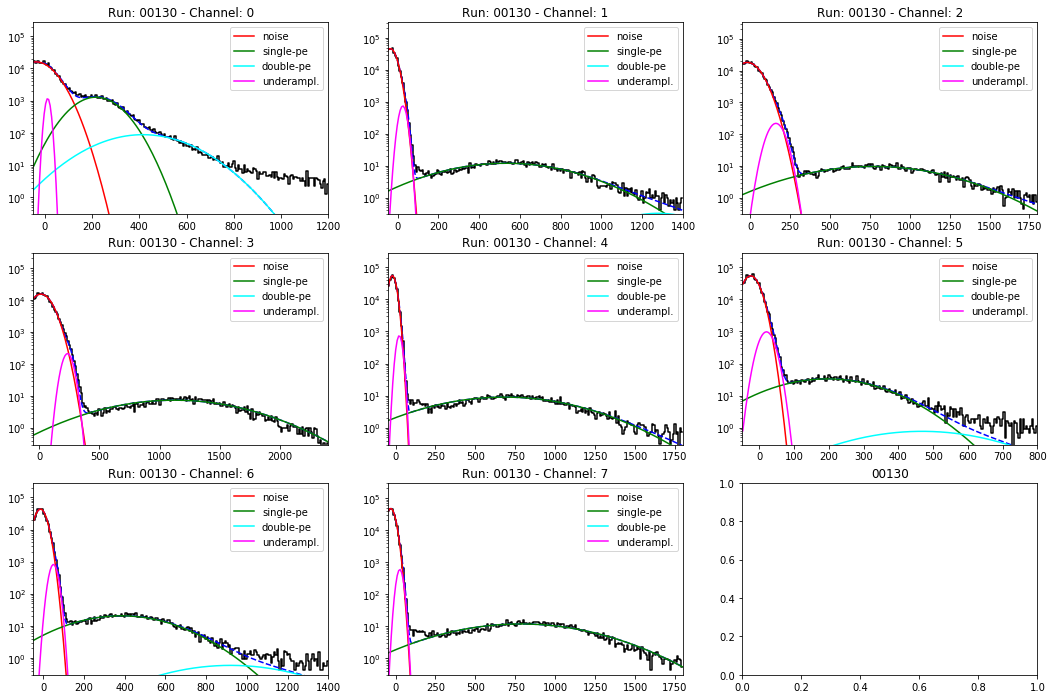

In [298]:
run = '00130'
gaindoc = PlotForRun(ctx, run)

### If fits are ok => push gain-document to database

In [44]:
with MongoClient(os.environ['MONGO_DAQ_URI']) as client:
    client['xebra_daq']['pmt_gains'].insert_one(gaindoc)

## All this is optional analysis:

In [291]:
raw = ctx.get_array('00130', 'raw_records')

In [292]:
hits = strax.find_hits(raw, threshold=50)
print(len(hits), 'hits')

1101879 hits


### Use this to identify / validate your window_low & window_high

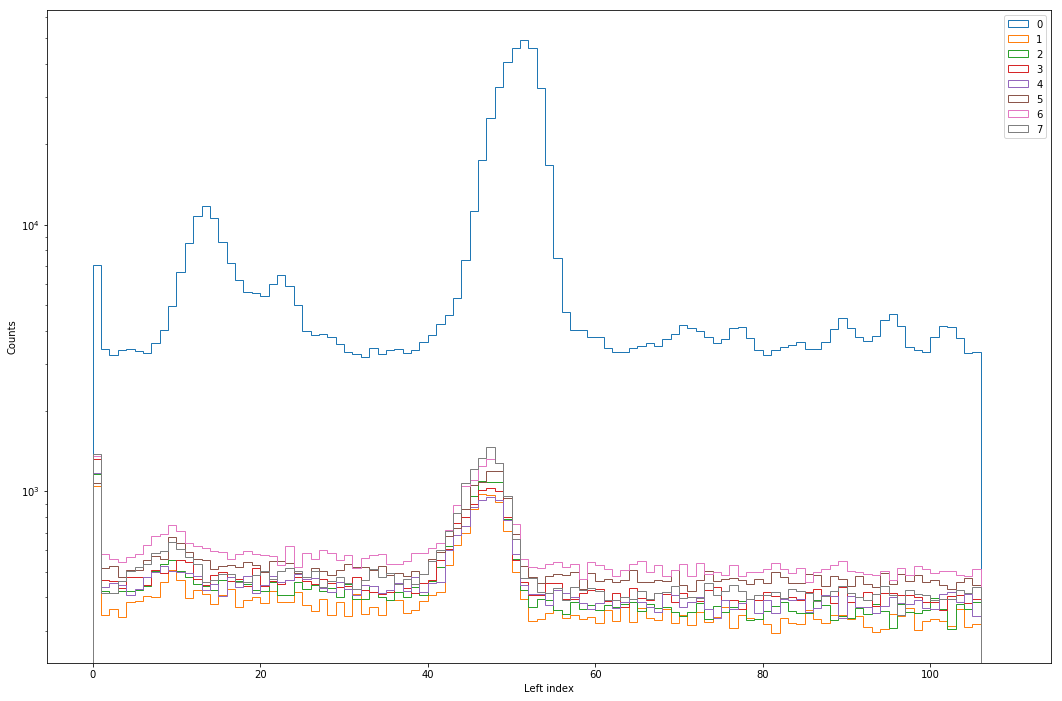

In [293]:
plt.figure(figsize=(18,12))
#m = (hits['right']-hits['left'])>0
for ch in range(8):
    #for ch in [7]:
    #m = hits['channel'] == ch
    #if ch == 5:
    #    continue
    plt.hist(hits['left'][(hits['channel'] == ch)], bins=np.arange(110), histtype='step', label=str(ch))
    #plt.hist(hits['right'][(hits['channel'] == ch)], bins=np.arange(110), histtype='step', label=str(ch))
plt.yscale('log')
plt.legend()
plt.xlabel('Left index')
plt.ylabel('Counts')
plt.show()

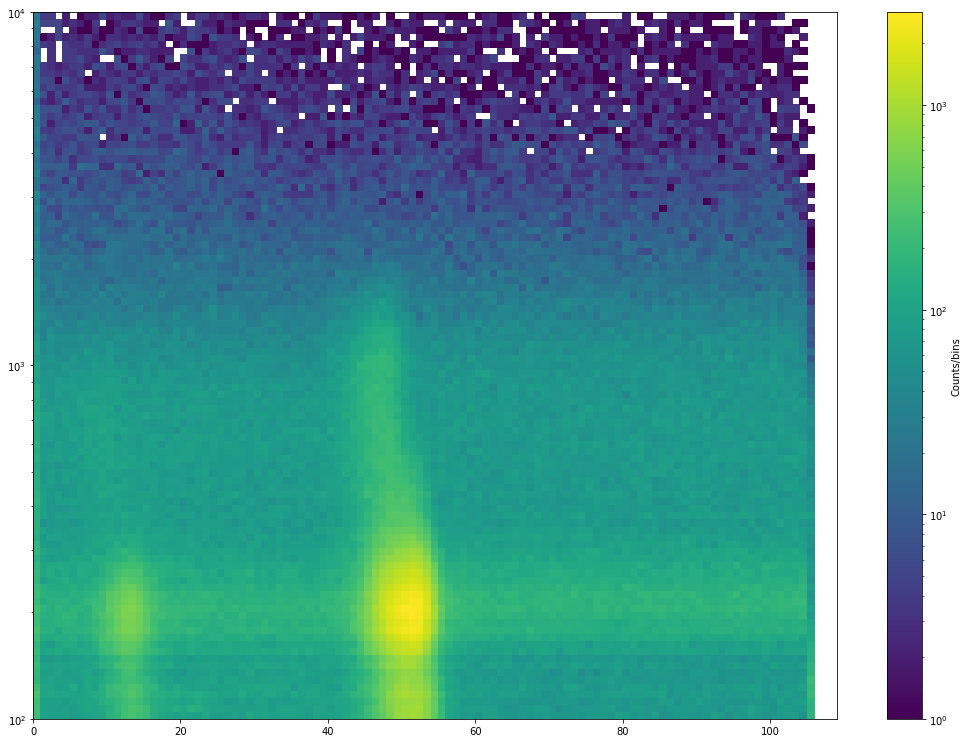

In [11]:
fig, ax = plt.subplots(figsize=(18,13))

bins_x = np.arange(110)
bins_y = np.logspace(2,4,100)

counts, _, _ = np.histogram2d(hits['left'], hits['area'], bins=(bins_x, bins_y))

im = ax.pcolormesh(bins_x, bins_y, counts.T, norm=mpl.colors.LogNorm())

ax.set_yscale('log')

cb = plt.colorbar(im,ax=ax,label='Counts/bins')

plt.show()


### Use this for freqency Analysis of noise contributions

In [97]:
ns = 1
GHz = 1/ns
freq_min = 1/(20000*ns)
freq_max = 0.1*GHz
freq = np.logspace(np.log10(freq_min), np.log10(freq_max), num=10000)
print(freq[0], 'Hz')
print(freq[-1], 'Hz')
amp = []
phase = []
d = []
for record_i in range(int(np.ceil(raw_rec[0]['pulse_length']/raw_rec[0]['length']))):
    d = np.append(d,raw_rec[0+8*record_i]['data'])
t = np.arange(len(d))*10
for fr in tqdm.tqdm(freq):
    re = (np.cos(2*np.pi*t*fr)*d).sum()
    im = (np.sin(2*np.pi*t*fr)*d).sum()
    amp.append(re*re+im*im)
    phase.append(np.arctan2(im,re))


  8%|▊         | 783/10000 [00:00<00:01, 7823.53it/s]

4.9999999999999996e-05 Hz
0.1 Hz



100%|██████████| 10000/10000 [00:01<00:00, 8752.17it/s]

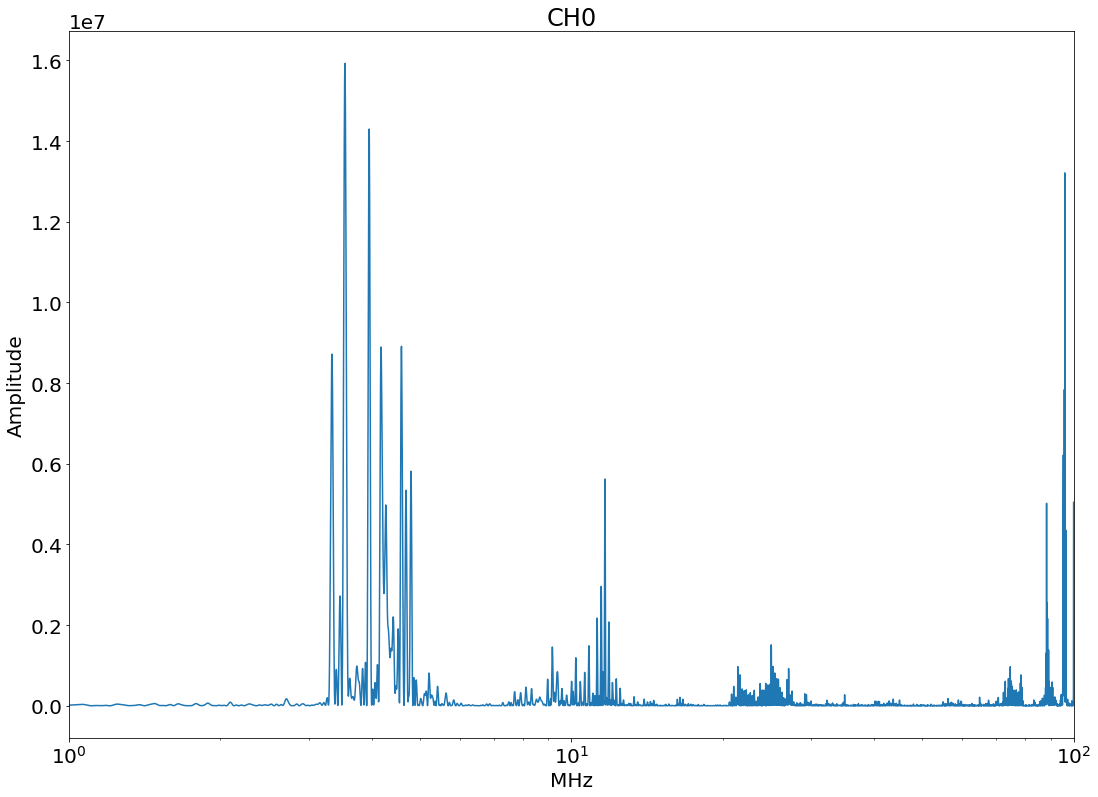

In [241]:
fig, ax_l = plt.subplots(figsize=(18,13))

ax_l.plot(freq*1e3, amp)
#ax_r = ax_l.twinx()
#ax_r.plot(freq*1e3, phase, c='r')

ax_l.set_xscale('log')
ax_l.set_xlabel('MHz')
#ax_r.set_ylabel('Phase')
ax_l.set_ylabel('Amplitude')
ax_l.set_xlim(1,100)
ax_l.set_title('CH0')
plt.show()

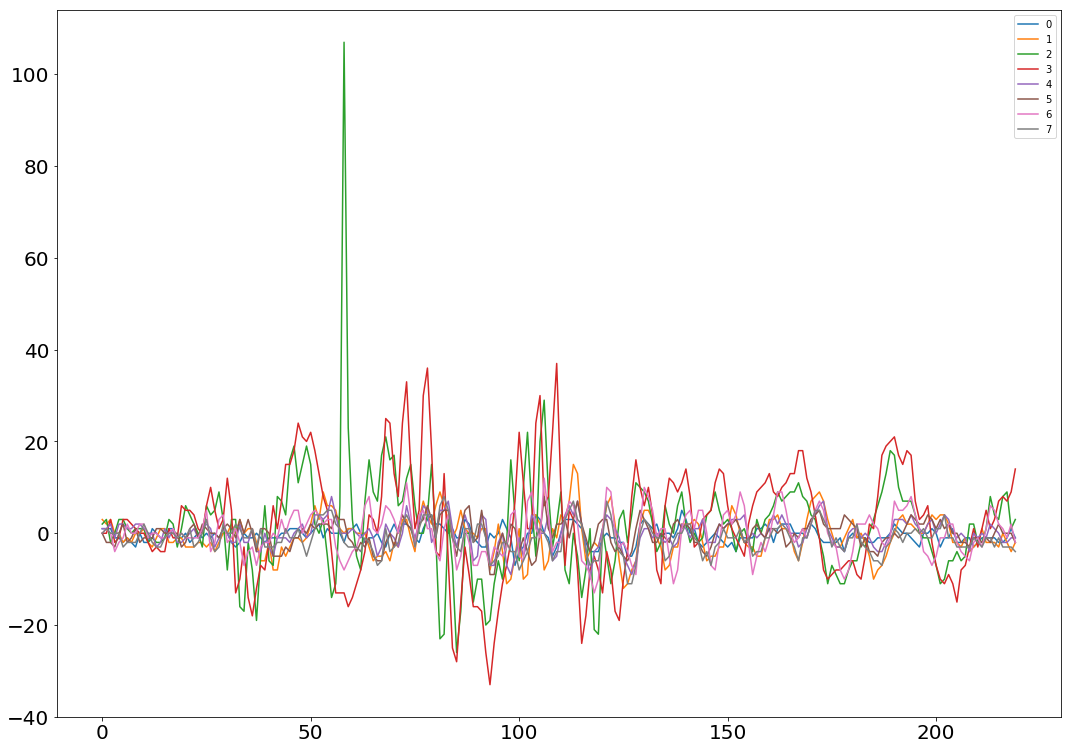

In [38]:
plt.figure(figsize=(18,13))
fragments_per_pulse = int(np.ceil(raw_rec[0]['pulse_length']/raw_rec[0]['length']))
channels = 8
tr_num = 35
offset = tr_num*fragments_per_pulse*channels
#print(len(raw_rec)/(fragments_per_pulse*channels))
for i in range(channels):
    d = []
    for record_i in range(int(np.ceil(raw_rec[offset+i]['pulse_length']/raw_rec[i]['length']))):
        d = np.append(d,raw_rec[offset+i+channels*record_i]['data'])
    plt.plot(d[:raw_rec[offset+i]["pulse_length"]], label=str(raw_rec[i]['channel']))
#plt.plot(raw_rec[1]['data'])

plt.legend()
plt.show()